In [2]:
import warnings
# Set warnings to ignore to keep output clean
warnings.filterwarnings('ignore')

In [117]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np

import results_plots
import my_statistics
import importlib
import utils

# Reload the module
importlib.reload(results_plots)
importlib.reload(my_statistics)

from results_plots import *
from my_statistics import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
# Obtain the arxiv data
with open("out/text/arxiv/lora_500_clamped_results.json") as f:
  arxiv_500_clamped = json.load(f)
with open("out/text/arxiv/lora_768_clamped_results.json") as f:
  arxiv_768_clamped = json.load(f)
with open("out/text/arxiv/lora_shuffled_results.json") as f:
  arxiv_shuffled = json.load(f)

# Obtain the oxford-pet data
with open("out/vision/oxford-pet/lora_clamped_results.json") as f:
  oxford_clamped = json.load(f)
with open("out/vision/oxford-pet/lora_shuffled_results.json") as f:
  oxford_shuffled = json.load(f)

# Obtain the stanford-dogs data
with open("out/vision/stanford-dogs/lora_clamped_results.json") as f:
  stanford_clamped = json.load(f)
with open("out/vision/stanford-dogs/lora_shuffled_results.json") as f:
  stanford_shuffled = json.load(f)

datasets = {
  "arxiv_500_clamped": arxiv_500_clamped,
  "arxiv_768_clamped": arxiv_768_clamped,
  "arxiv_shuffled": arxiv_shuffled,
  "oxford_clamped": oxford_clamped,
  "oxford_shuffled": oxford_shuffled,
  "stanford_clamped": stanford_clamped,
  "stanford_shuffled": stanford_shuffled
}

In [119]:
def trim_data(dataset, clamp_indices=500, num_layers=12):
    for key in dataset.keys():
        for i in range(num_layers):
            layer = 'layer_' + str(i)
            for attn_matrix in ['key', 'query', 'value']:
                dataset[key]['SVD Diagonal Entries'][layer][attn_matrix] = dataset[key]['SVD Diagonal Entries'][layer][attn_matrix][:clamp_indices]
    return dataset

In [120]:
# Preprocess datasets:
for key in datasets.keys():
    dataset = datasets[key]
    clamp_indices = 500
    if key == "arxiv_768_clamped":
        clamp_indices = 768
    dataset = trim_data(dataset, clamp_indices=clamp_indices)
    datasets[key] = add_intrinsic_dimension_coeffs(dataset)

In [110]:
for key in datasets['arxiv_500_clamped'].keys():
    print(len(key.split('-')), gini_coefficient(datasets['arxiv_500_clamped'][key]['SVD Diagonal Entries']['layer_0']['key']))

20 0.9806969225623179
40 0.9828684351152625
60 0.9853700515517266
80 0.9852119499727269
100 0.9849392229976366
120 0.9855495798912598
20 0.9819106189221493
40 0.9841618100331397
60 0.9830118411308504
80 0.984511545343441
100 0.9856157027805457
120 0.9845947856167914
20 0.9818933445479487
40 0.9820542037740233
60 0.9834547125661047
80 0.9822121633255155
100 0.9851474910942488
120 0.9848498558637221
20 0.9827661439192598
40 0.9824540299077634
60 0.9844446078537731
80 0.9834356490957434
100 0.9823353341048351
120 0.9847618301049806
20 0.9797077337799128
40 0.9825071550401626
60 0.9829776589388494
80 0.9831286061801947
100 0.9827506484835176
120 0.9847054793570423
20 0.9797271693487419
40 0.9842064024983556
60 0.9825466148433043
80 0.9820905879196944
100 0.984011517802428
120 0.9838182372174924
20 0.979437786310853
40 0.9819732627923949
60 0.9832042642964516
80 0.9837261169396807
100 0.9839990784146357
120 0.9839138585079927
20 0.981438188360713
40 0.9838008247868857
60 0.982057898742496
8

In [8]:
dataset = datasets["arxiv_500_clamped"]
test_key = list(dataset.keys())[0]
dataset[test_key].keys()

dict_keys(['Metrics', 'SVD Diagonal Entries', 'Coefficients'])

In [9]:
one_run = {}
for run, data in datasets["arxiv_500_clamped"].items():
    num_classes = int(len(run.split('-')))
    if num_classes not in one_run:
        one_run[num_classes] = run
one_run.keys()
runs500 = list(one_run.values())

In [15]:
one_run = {}
for run, data in datasets["arxiv_768_clamped"].items():
    num_classes = int(len(run.split('-')))
    if num_classes not in one_run:
        one_run[num_classes] = run
one_run.keys()
runs768 = list(one_run.values())

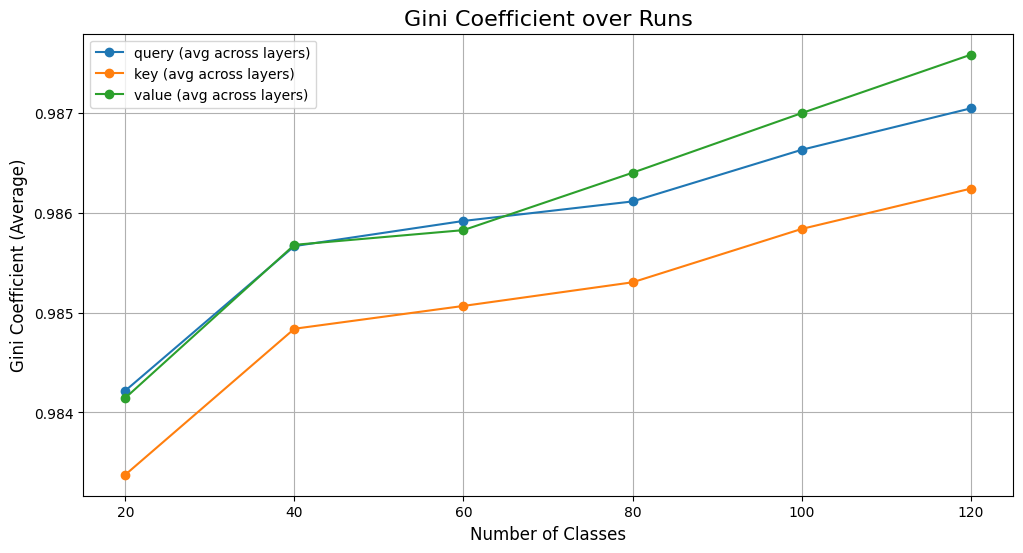

In [107]:
plot_coefficients_over_runs(datasets["arxiv_500_clamped"], "gini", x_axis="num_classes", combine_runs=True, combine_layers=True, combine_method="average")

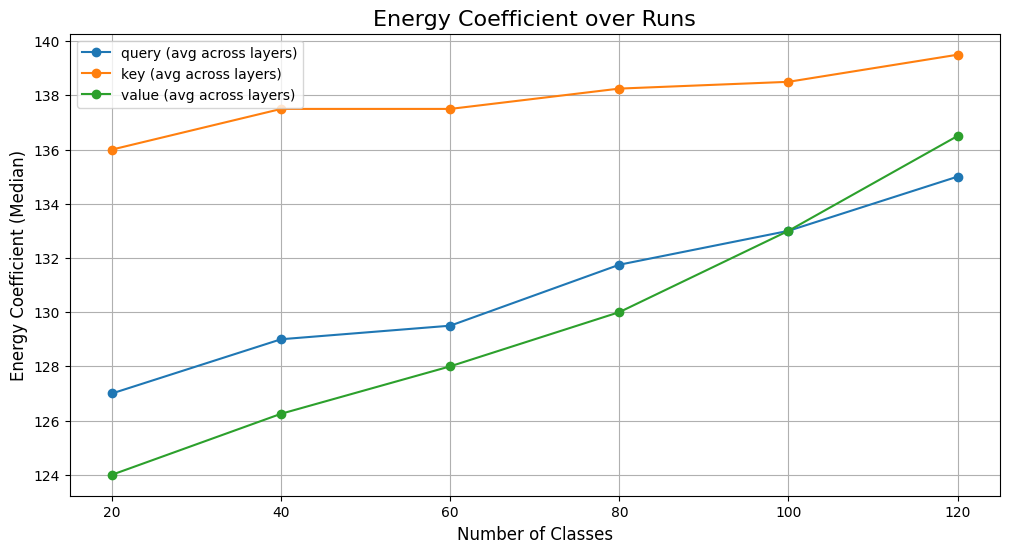

In [44]:
plot_coefficients_over_runs(datasets["stanford_clamped"], "energy", x_axis="num_classes", combine_runs=True, combine_layers=True, combine_method="median")

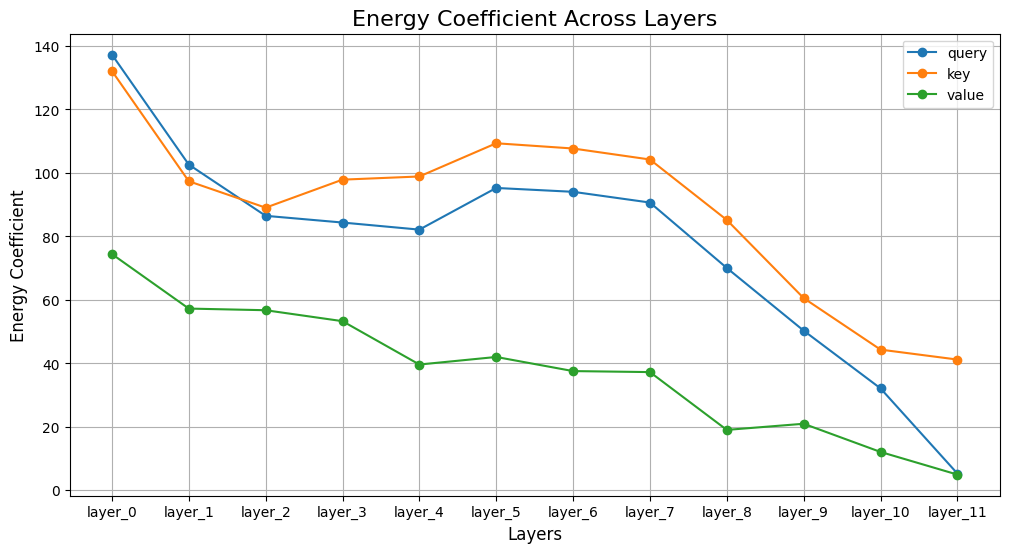

In [45]:
plot_coefficients_across_layers_or_runs(datasets["arxiv_500_clamped"], "energy", mode="layers", combine_runs=True)

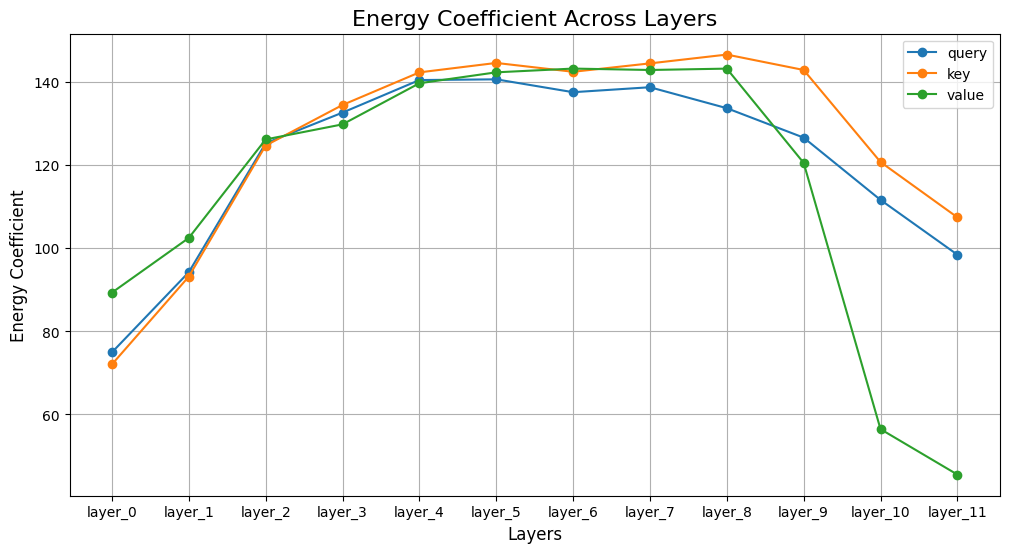

In [148]:
plot_coefficients_across_layers_or_runs(datasets["stanford_clamped"], "energy", mode="layers", combine_runs=True)

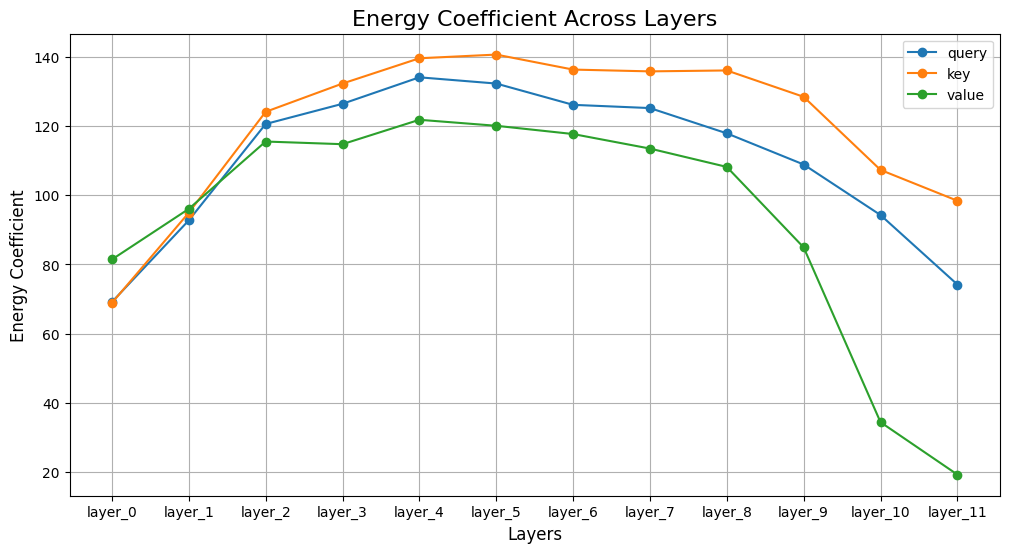

In [149]:
plot_coefficients_across_layers_or_runs(datasets["oxford_clamped"], "energy", mode="layers", combine_runs=True)

In [49]:
# Obtaining the train data
with open("out/text/fine-tune_metric_results.json") as f:
  text_training_data = json.load(f)
with open("out/vision/fine-tune_metric_results.json") as f:
  vision_training_data = json.load(f)
fine_tune_metric_results = {
  "arxiv" : text_training_data["arxiv"],
  "oxford-pet" : vision_training_data["oxford-pet"],
  "stanford-dogs" : vision_training_data["stanford-dogs"]
}

In [50]:
fine_tune_metric_results.keys()

dict_keys(['arxiv', 'oxford-pet', 'stanford-dogs'])

In [59]:
# Obtaining best accuracy for each number of classes
def gather_best(data, dataset):
  output = {}

  for key in data[dataset].keys():
      best_acc = data[dataset][key]['Best Results']['Validation Accuracy']
      num_classes = len(key.split('-'))

      if num_classes not in output:
          output[num_classes] = []

      output[num_classes].append(best_acc)
  
  return output

best_accs_arxiv = gather_best(fine_tune_metric_results, 'arxiv')
best_accs_stan = gather_best(fine_tune_metric_results, 'stanford-dogs')
best_accs_ox = gather_best(fine_tune_metric_results, 'oxford-pet')

del best_accs_arxiv[max(best_accs_arxiv.keys())]
del best_accs_stan[max(best_accs_stan.keys())]
del best_accs_ox[max(best_accs_ox.keys())]

For the Arxiv dataset:


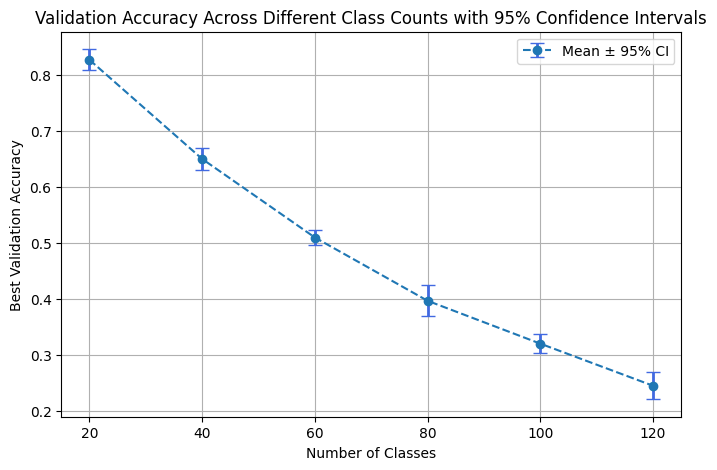

For the Stanford Dog dataset:


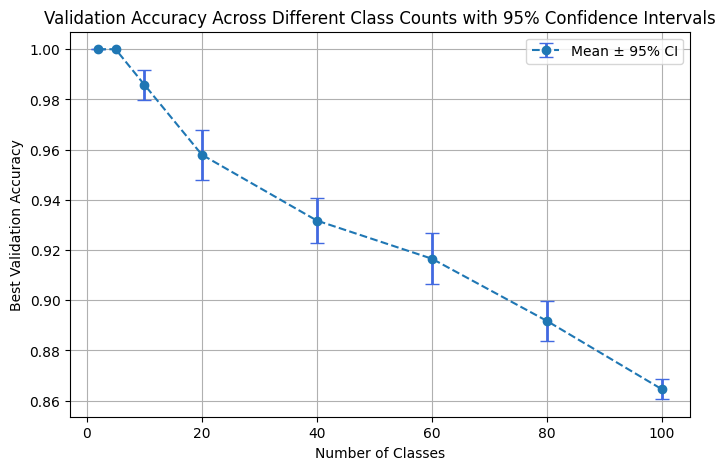

For the Oxford Pet dataset:


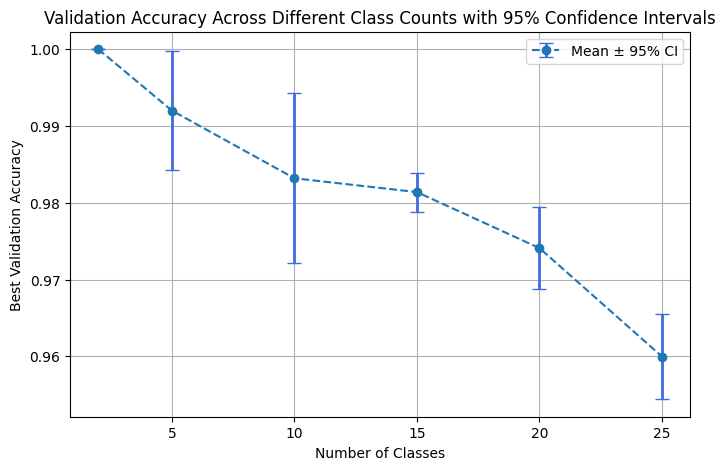

In [61]:
# Plotting best accuracies vs. number of classes
def plot_finetune_data(dataset_train_data):
    plt.figure(figsize=(8, 5))
    
    # Extract x values and corresponding y arrays
    x_values = list(dataset_train_data.keys())
    y_values = [np.array(dataset_train_data[x]) for x in x_values]

    # Compute mean and confidence intervals
    means = [np.mean(y) for y in y_values]
    std_devs = [np.std(y, ddof=1) for y in y_values]
    sample_sizes = [len(y) for y in y_values]
    conf_intervals = [1.96 * (std / np.sqrt(n)) for std, n in zip(std_devs, sample_sizes)]

    # Sort data by x-values
    sorted_data = sorted(zip(x_values, means, conf_intervals), key=lambda x: x[0])
    x_sorted, means_sorted, conf_intervals_sorted = zip(*sorted_data)

    # Plot the means and confidence intervals using error bars
    plt.errorbar(
        x_sorted, 
        means_sorted, 
        yerr=conf_intervals_sorted, 
        fmt="--o", 
        ecolor='royalblue', 
        elinewidth=2, 
        capsize=5, 
        label='Mean ± 95% CI'
    )

    # Add labels, legend, and grid
    plt.xlabel('Number of Classes')
    plt.ylabel('Best Validation Accuracy')
    plt.title('Validation Accuracy Across Different Class Counts with 95% Confidence Intervals')
    plt.legend()
    plt.grid(True)
    return plt.show()

print("For the Arxiv dataset:")
plot_finetune_data(best_accs_arxiv)
print("For the Stanford Dog dataset:")
plot_finetune_data(best_accs_stan)
print("For the Oxford Pet dataset:")
plot_finetune_data(best_accs_ox)

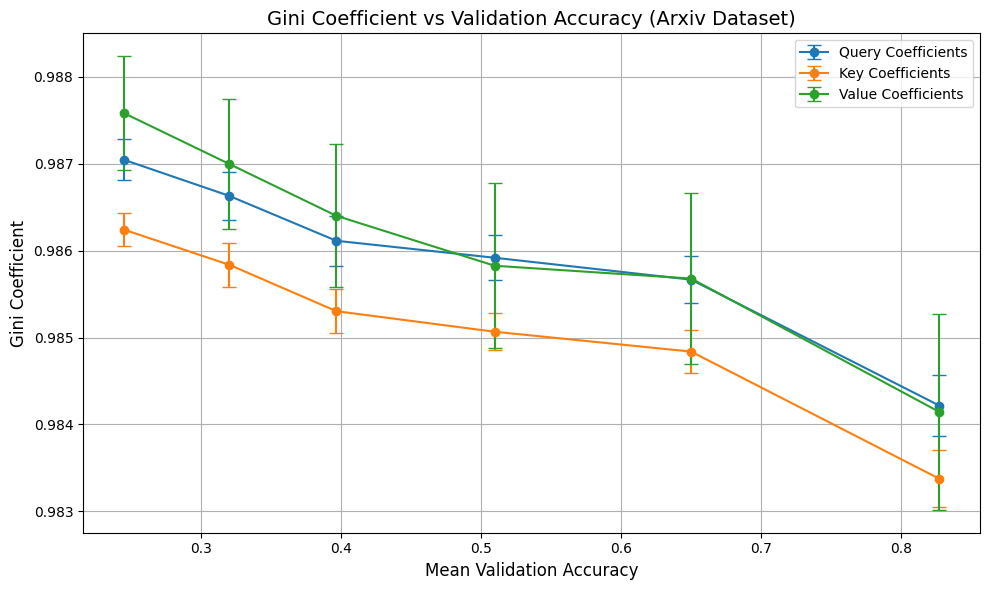

In [95]:
plot_coefficients_with_accuracy(
    results=datasets["arxiv_500_clamped"], 
    coefficient_name="gini", 
    accuracies_dict=best_accs_arxiv, 
    title="Gini Coefficient vs Validation Accuracy (Arxiv Dataset)",
    ylabel="Gini Coefficient",
    combine_matrices=False
)

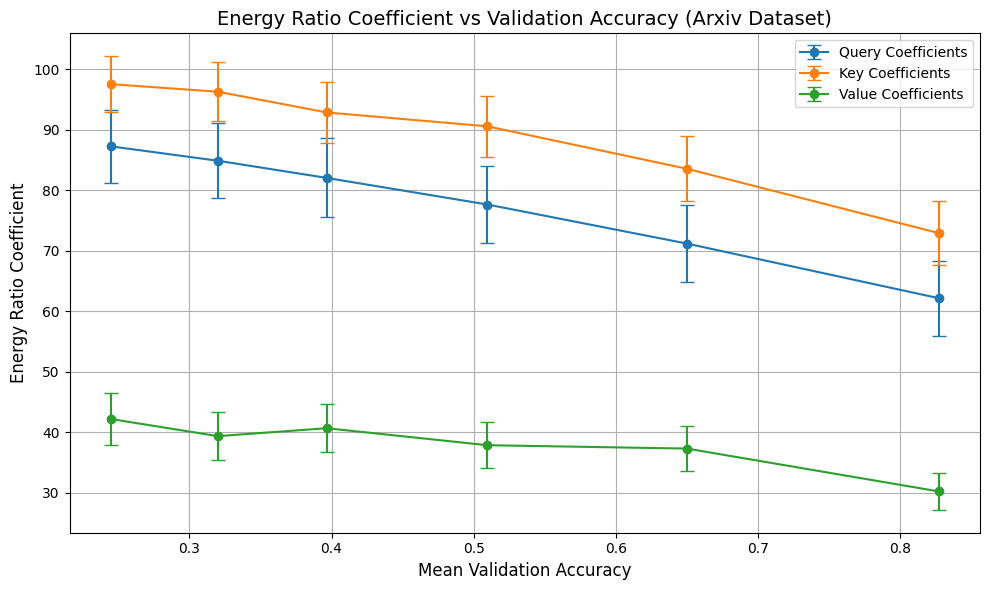

In [94]:
plot_coefficients_with_accuracy(
    results=datasets["arxiv_500_clamped"], 
    coefficient_name="energy", 
    accuracies_dict=best_accs_arxiv, 
    title="Energy Ratio Coefficient vs Validation Accuracy (Arxiv Dataset)",
    ylabel="Energy Ratio Coefficient",
    combine_matrices=False
)

In [88]:
best_accs_stan = {key: best_accs_stan[key] for key in sorted(best_accs_stan)}

print(best_accs_stan)

{2: [1.0, 1.0], 5: [1.0], 10: [0.9672131147540983, 0.985781990521327, 0.9947089947089947, 0.9893617021276596, 0.9740932642487047, 0.9902912621359223, 0.9885714285714285, 0.9942528735632183, 0.9886363636363636], 20: [0.9468085106382979, 0.9794117647058823, 0.9451371571072319, 0.978319783197832, 0.9584415584415584, 0.9692737430167597, 0.9347181008902077, 0.967032967032967, 0.9624664879356568, 0.9380053908355795], 40: [0.9551374819102749, 0.939106901217862, 0.9396170839469808, 0.9342657342657342, 0.9507042253521126, 0.9217032967032966, 0.9412607449856734, 0.8988326848249028, 0.9269340974212035, 0.9124293785310734, 0.9220055710306406, 0.9386666666666666], 60: [0.9262135922330097, 0.8862385321100917, 0.9007561436672968, 0.9298401420959147, 0.9184782608695652, 0.9364791288566243, 0.8979033728350045, 0.9237132352941176, 0.9297929792979298, 0.9158279963403476], 80: [0.8777078965758212, 0.8971308607417775, 0.8989547038327527, 0.8995247793618466, 0.8632302405498282, 0.8898954703832752, 0.8995726

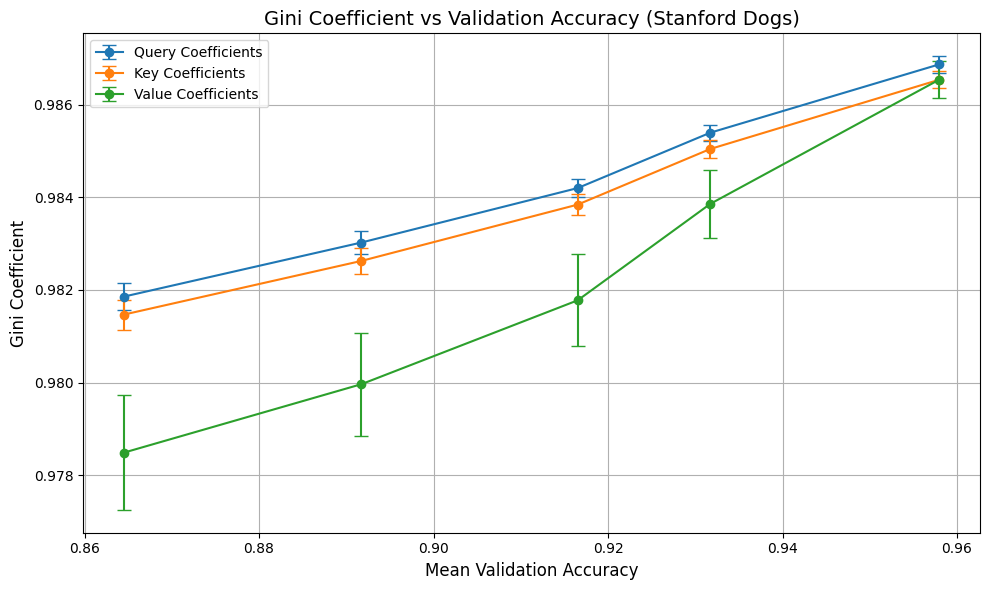

In [92]:
plot_coefficients_with_accuracy(
    results=datasets["stanford_clamped"], 
    coefficient_name="gini", 
    accuracies_dict=best_accs_stan, 
    title="Gini Coefficient vs Validation Accuracy (Stanford Dogs)",
    ylabel="Gini Coefficient",
    combine_matrices=False
)

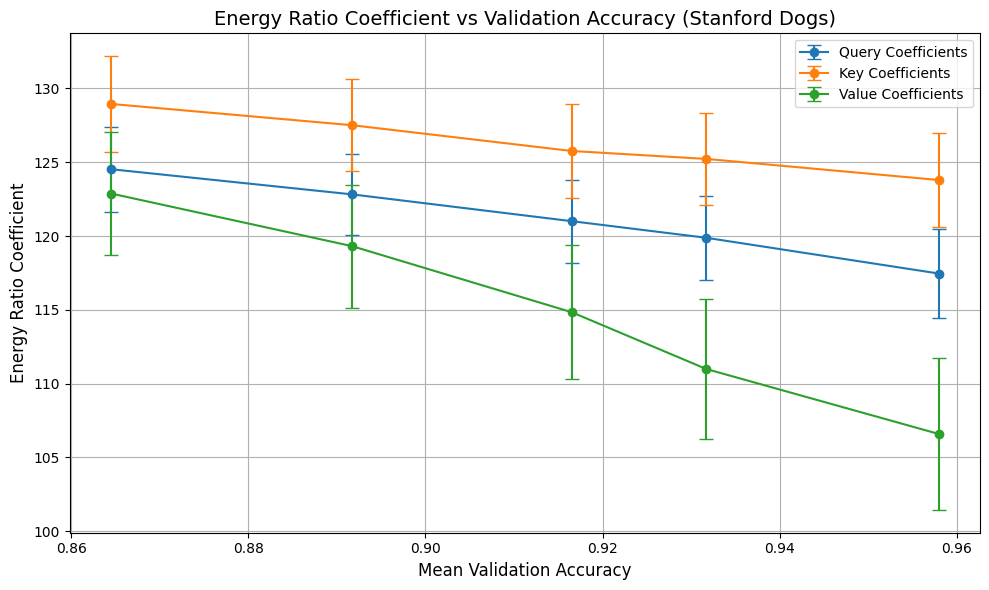

In [93]:
plot_coefficients_with_accuracy(
    results=datasets["stanford_clamped"], 
    coefficient_name="energy", 
    accuracies_dict=best_accs_stan, 
    title="Energy Ratio Coefficient vs Validation Accuracy (Stanford Dogs)",
    ylabel="Energy Ratio Coefficient",
    combine_matrices=False
)

# Final Graphs Plotted Here:

### First Graph: Proxy for Task Complexity
This first plot will show the linear correlation between the validation accuracy and the number of classes used in the classification task.

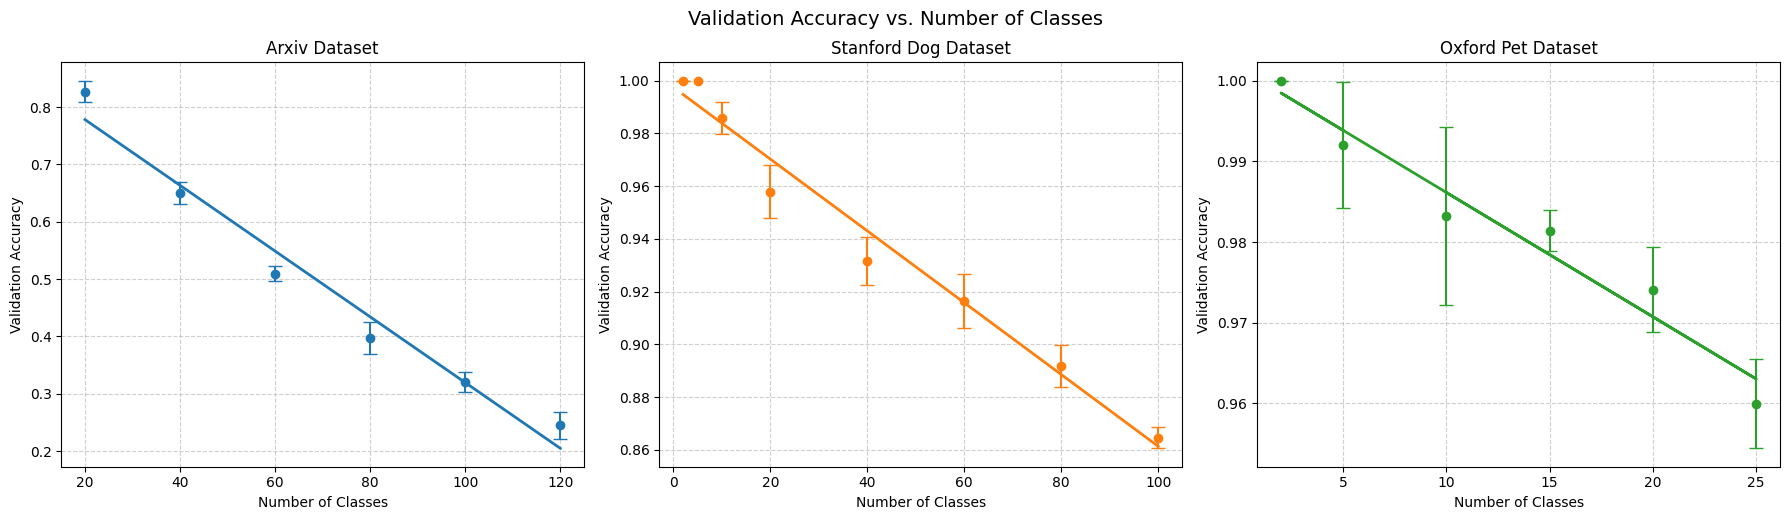

Arxiv Dataset: Slope = -0.0057, Intercept = 0.8926, R^2 = 0.9700
Stanford Dog Dataset: Slope = -0.0014, Intercept = 0.9975, R^2 = 0.9770
Oxford Pet Dataset: Slope = -0.0015, Intercept = 1.0016, R^2 = 0.9550


In [146]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, sem

def plot_finetune_data_side_by_side(dataset_dicts, dataset_names):
    """
    Plots validation accuracy vs. number of classes for multiple datasets in a single row of subplots.
    Fits a line of best fit instead of connecting data points.
    Includes 95% confidence intervals for the data points.
    Outputs slope, intercept, and r^2 values for reference.

    Args:
        dataset_dicts: List of dictionaries containing {num_classes: [accuracies]} for each dataset.
        dataset_names: List of names corresponding to the datasets.
    """
    num_datasets = len(dataset_dicts)
    fig, axes = plt.subplots(1, num_datasets, figsize=(6 * num_datasets, 5), sharey=False)
    
    # Output for slopes, intercepts, and r^2 values
    results = []

    # Colors for academic style
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Loop through each dataset and plot on its respective axis
    for idx, (dataset_data, dataset_name) in enumerate(zip(dataset_dicts, dataset_names)):
        ax = axes[idx] if num_datasets > 1 else axes
        
        # Extract x-values and mean y-values
        x_values = np.array(list(dataset_data.keys()))
        y_means = np.array([np.mean(dataset_data[x]) for x in x_values])
        y_cis = np.array([1.96 * sem(dataset_data[x]) for x in x_values])  # 95% Confidence Intervals

        # Fit line of best fit
        slope, intercept, r_value, _, _ = linregress(x_values, y_means)
        line_of_best_fit = slope * x_values + intercept
        
        # Save results for paper reference
        results.append((dataset_name, slope, intercept, r_value**2))
        
        # Plot data points with confidence intervals and line of best fit
        ax.errorbar(x_values, y_means, yerr=y_cis, fmt='o', color=colors[idx % len(colors)], 
                    capsize=5, label='Data Points (95% CI)', zorder=3)
        ax.plot(x_values, line_of_best_fit, color=colors[idx % len(colors)], linestyle='-', linewidth=2, 
                label='Line of Best Fit')
        
        # Customize each subplot
        ax.set_title(dataset_name, fontsize=12)
        ax.set_xlabel('Number of Classes', fontsize=10)
        ax.set_ylabel('Validation Accuracy', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        # ax.legend()
    
    # Overall figure adjustments
    plt.tight_layout()
    plt.suptitle('Validation Accuracy vs. Number of Classes', fontsize=14, y=1.03)
    plt.show()
    
    # Output results
    for name, slope, intercept, r_squared in results:
        print(f"{name}: Slope = {slope:.4f}, Intercept = {intercept:.4f}, R^2 = {r_squared:.4f}")

# Combine data and names into lists
accuracies = [best_accs_arxiv, best_accs_stan, best_accs_ox]
dataset_names = ['Arxiv Dataset', 'Stanford Dog Dataset', 'Oxford Pet Dataset']

# Plot all datasets side by side
plot_finetune_data_side_by_side(accuracies, dataset_names)


Arxiv Dataset - Query Matrix: Slope = -43.2210, Intercept = 98.7716, R^2 = 0.9936
Arxiv Dataset - Key Matrix: Slope = -41.9812, Intercept = 109.5985, R^2 = 0.9672
Arxiv Dataset - Value Matrix: Slope = -17.8866, Intercept = 46.6942, R^2 = 0.8670
Stanford Dog Dataset - Query Matrix: Slope = -75.0689, Intercept = 189.6454, R^2 = 0.9916
Stanford Dog Dataset - Key Matrix: Slope = -55.3455, Intercept = 176.7620, R^2 = 0.9941
Stanford Dog Dataset - Value Matrix: Slope = -178.4612, Intercept = 277.7653, R^2 = 0.9896
Oxford Pet Dataset - Query Matrix: Slope = -379.4322, Intercept = 480.1367, R^2 = 0.8757
Oxford Pet Dataset - Key Matrix: Slope = -276.1598, Intercept = 389.4738, R^2 = 0.8845
Oxford Pet Dataset - Value Matrix: Slope = -464.3846, Intercept = 546.4818, R^2 = 0.8871


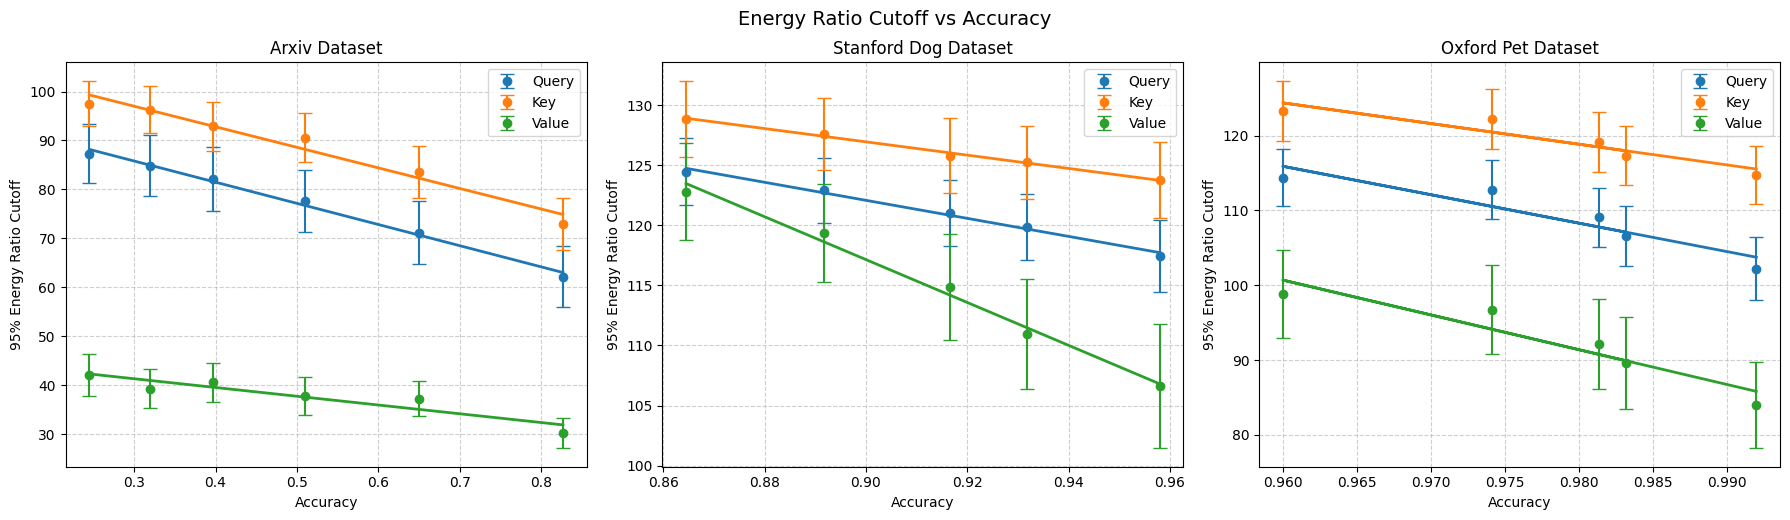

In [143]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def collect_class_coefficients(results_list, dataset_names):
    """
    Collects energy coefficients for Q, K, V matrices grouped by class count across multiple datasets.

    Args:
        results_list (list of dicts): A list of results for each dataset.
        dataset_names (list of str): Names of the datasets.

    Returns:
        dict: A nested dictionary with structure:
              {
                dataset_name: {
                    class_count: {
                        'query': [...coefficients...],
                        'key': [...coefficients...],
                        'value': [...coefficients...]
                    }
                }
              }
    """
    class_coefficients = {}
    for dataset_name in dataset_names:
        class_coefficients[dataset_name] = defaultdict(lambda: {"query": [], "key": [], "value": []})

    # Loop through each dataset and collect coefficients by class count
    for results, dataset_name in zip(results_list, dataset_names):
        for run_name, run_data in results.items():
            # Extract class count from the run name, assuming format 'run_<class_count>'
            try:
                class_count = len(run_name.split('-'))
            except (IndexError, ValueError):
                print(f"Warning: Unable to parse class count from run name: {run_name}")
                continue

            # Collect coefficients for each layer and matrix type
            for layer in run_data["SVD Diagonal Entries"]:
                for matrix_type in ["query", "key", "value"]:
                    coeff_value = run_data["Coefficients"]["energy"][layer][matrix_type]
                    class_coefficients[dataset_name][class_count][matrix_type].append(coeff_value)

    return class_coefficients

def plot_class_coefficients_with_accuracy(class_coeffs, accuracies_list, dataset_names):
    """
    Plots energy coefficients (Q, K, V) against mean accuracies for each dataset.
    Fits a line of best fit for each matrix type, includes confidence intervals, and prints regression details.

    Args:
        class_coeffs (dict): Coefficients collected by class count and matrix type.
        accuracies_list (list of dicts): A list of dictionaries with accuracies grouped by class count.
        dataset_names (list of str): Names of the datasets.
    """
    num_datasets = len(dataset_names)
    fig, axes = plt.subplots(1, num_datasets, figsize=(6 * num_datasets, 5), sharey=False)

    # Colors for Q, K, V matrices
    colors = {"query": "#1f77b4", "key": "#ff7f0e", "value": "#2ca02c"}

    for idx, (dataset_name, accuracies_dict) in enumerate(zip(dataset_names, accuracies_list)):
        ax = axes[idx] if num_datasets > 1 else axes

        # Retrieve coefficients and accuracies by class count
        class_data = class_coeffs[dataset_name]
        x_values = []
        y_values = {"query": [], "key": [], "value": []}
        y_cis = {"query": [], "key": [], "value": []}

        for class_count, accuracies in accuracies_dict.items():
            mean_accuracy = np.mean(accuracies)
            x_values.append(mean_accuracy)

            for matrix_type in ["query", "key", "value"]:
                coeffs = class_data[class_count][matrix_type]
                if coeffs:  # Ensure there are coefficients to calculate
                    mean_coeff = np.mean(coeffs)
                    ci_coeff = 1.96 * (np.std(coeffs, ddof=1) / np.sqrt(len(coeffs))) if len(coeffs) > 1 else 0
                    y_values[matrix_type].append(mean_coeff)
                    y_cis[matrix_type].append(ci_coeff)
                else:
                    y_values[matrix_type].append(None)
                    y_cis[matrix_type].append(0)

        # Fit and plot line of best fit for Q, K, V
        for matrix_type in ["query", "key", "value"]:
            valid_x = np.array([x for x, y in zip(x_values, y_values[matrix_type]) if y is not None])
            valid_y = np.array([y for y in y_values[matrix_type] if y is not None])
            valid_cis = np.array([ci for y, ci in zip(y_values[matrix_type], y_cis[matrix_type]) if y is not None])

            if len(valid_x) > 1:  # Perform linear regression if enough points exist
                slope, intercept, r_value, _, _ = linregress(valid_x, valid_y)
                fit_line = slope * valid_x + intercept

                # Print regression details
                print(f"{dataset_name} - {matrix_type.capitalize()} Matrix: Slope = {slope:.4f}, Intercept = {intercept:.4f}, R^2 = {r_value**2:.4f}")

                # Plot scatter, confidence intervals, and line of best fit
                ax.errorbar(valid_x, valid_y, yerr=valid_cis, fmt='o', color=colors[matrix_type], capsize=5, label=matrix_type.capitalize())
                ax.plot(valid_x, fit_line, color=colors[matrix_type], linestyle='-', linewidth=2)

        # Customize subplot
        ax.set_title(dataset_name, fontsize=12)
        ax.set_xlabel("Accuracy", fontsize=10)
        ax.set_ylabel("95% Energy Ratio Cutoff", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc="upper right")

    plt.tight_layout()
    plt.suptitle("Energy Ratio Cutoff vs Accuracy", fontsize=14, y=1.03)
    plt.show()

# Example usage
accuracies = [best_accs_arxiv, best_accs_stan, best_accs_ox]
dataset_list = [datasets['arxiv_500_clamped'], datasets['stanford_clamped'], datasets['oxford_clamped']]
dataset_names = ["Arxiv Dataset", "Stanford Dog Dataset", "Oxford Pet Dataset"]


# Collect coefficients grouped by class
class_coeffs = collect_class_coefficients(dataset_list, dataset_names)

# Plot coefficients against mean accuracies
plot_class_coefficients_with_accuracy(class_coeffs, accuracies, dataset_names)


12
Arxiv Dataset - Query Matrix: Slope = 58.9958, Intercept = 40.5148, R^2 = 0.8152
Arxiv Dataset - Key Matrix: Slope = 52.8777, Intercept = 58.4423, R^2 = 0.8528
Arxiv Dataset - Value Matrix: Slope = 19.2589, Intercept = 17.3891, R^2 = 0.5715
Stanford Dog Dataset - Query Matrix: Slope = 4.6696, Intercept = 124.5088, R^2 = 0.7651
Stanford Dog Dataset - Key Matrix: Slope = 1.7768, Intercept = 128.3304, R^2 = 0.1703
Stanford Dog Dataset - Value Matrix: Slope = 3.5132, Intercept = 119.6230, R^2 = 0.7595
Oxford Pet Dataset - Query Matrix: Slope = 18.6747, Intercept = 120.8576, R^2 = 0.9493
Oxford Pet Dataset - Key Matrix: Slope = 13.8142, Intercept = 125.1094, R^2 = 0.8034
Oxford Pet Dataset - Value Matrix: Slope = 28.5977, Intercept = 112.7096, R^2 = 0.9539


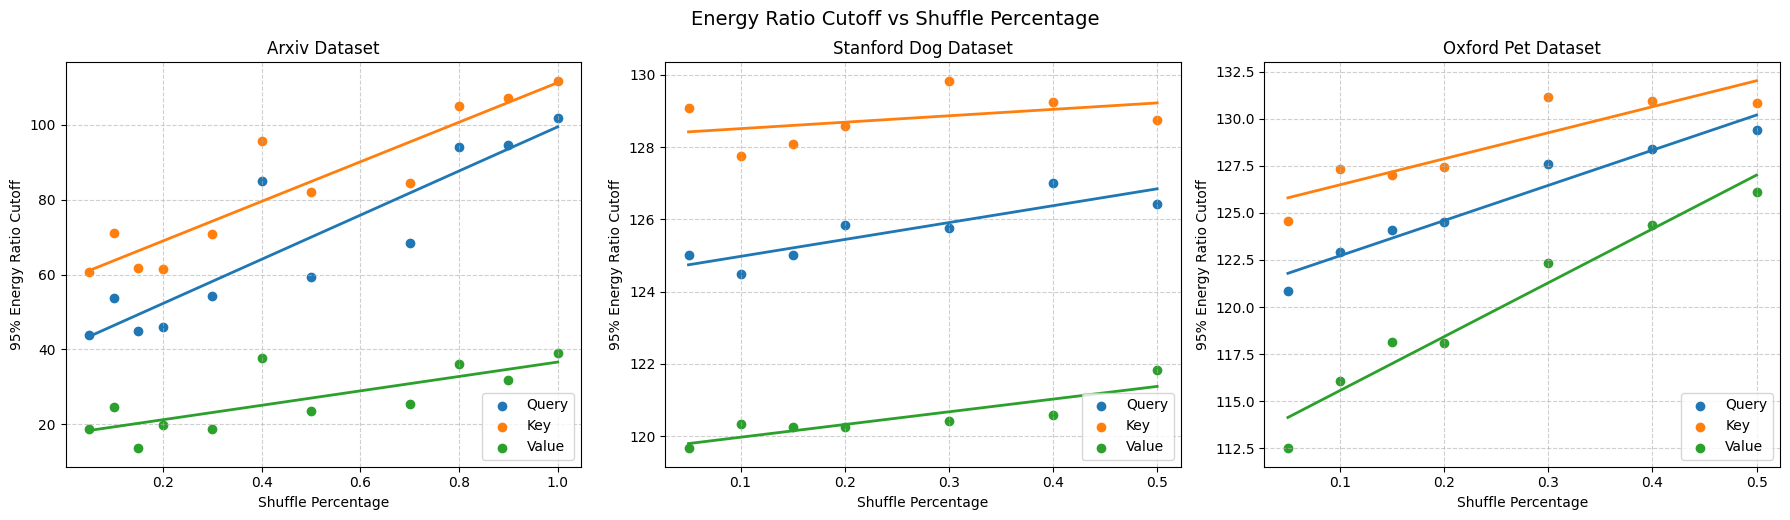

In [173]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, sem

def extract_energy_coefficients_by_percentage(dataset, coefficient_name="energy"):
    """
    Extracts energy coefficients for all layers in a given dataset grouped by percentage values in the keys,
    and stores them separately for 'query', 'key', and 'value'.

    Args:
        dataset (dict): A dataset dictionary where keys include percentages.
        coefficient_name (str): Name of the coefficient to extract (default is "energy").

    Returns:
        dict: A dictionary with percentages as keys and another dictionary as values containing
              'query', 'key', and 'value' lists of energy coefficients.
              Example:
              {
                0.1: {'query': [coeff1, coeff2], 'key': [coeff1, coeff2], 'value': [coeff1, coeff2]},
                0.2: {'query': [...], 'key': [...], 'value': [...]},
                ...
              }
    """
    percentage_coeffs = {}

    for key, run_data in dataset.items():
        # Extract percentage from key
        try:
            percentage = float(key.split(": ")[0])  # Convert percentage to float
        except (IndexError, ValueError):
            print(f"Skipping invalid key format: {key}")
            continue

        # Initialize matrix types for the current percentage
        if percentage not in percentage_coeffs:
            percentage_coeffs[percentage] = {"query": [], "key": [], "value": []}

        # Extract coefficients for each layer and matrix type
        for layer in run_data.get("SVD Diagonal Entries", {}).keys():
            for matrix_type in ["query", "key", "value"]:
                coeff = run_data.get("Coefficients", {}).get(coefficient_name, {}).get(layer, {}).get(matrix_type)
                if coeff is not None:
                    percentage_coeffs[percentage][matrix_type].append(coeff)

    return percentage_coeffs



def plot_average_energy_vs_percentage(coeffs_list, dataset_names):
    """
    Plots the average energy coefficients against shuffle percentages for Q, K, V matrices.
    Fits a line of best fit for each matrix type and excludes error bars.

    Args:
        coeffs_list (list): A list of dictionaries containing energy coefficients grouped by percentage.
        dataset_names (list): Names of the datasets corresponding to the coefficients.
    """
    num_datasets = len(dataset_names)
    fig, axes = plt.subplots(1, num_datasets, figsize=(6 * num_datasets, 5), sharey=False)

    # Colors for Q, K, V matrices
    colors = {"query": "#1f77b4", "key": "#ff7f0e", "value": "#2ca02c"}

    for idx, (coeffs, dataset_name) in enumerate(zip(coeffs_list, dataset_names)):
        ax = axes[idx] if num_datasets > 1 else axes
        
        percentages = np.array(sorted(coeffs.keys()))
        y_values = {"query": [], "key": [], "value": []}

        # Collect mean values
        for percentage in percentages:
            for matrix_type in ["query", "key", "value"]:
                values = coeffs[percentage][matrix_type]
                if values:
                    mean_value = np.mean(values)
                    y_values[matrix_type].append(mean_value)
                else:
                    y_values[matrix_type].append(None)

        # Fit and plot line of best fit without error bars
        for matrix_type in ["query", "key", "value"]:
            valid_x = np.array([x for x, y in zip(percentages, y_values[matrix_type]) if y is not None])
            valid_y = np.array([y for y in y_values[matrix_type] if y is not None])

            if len(valid_x) > 1:
                slope, intercept, r_value, _, _ = linregress(valid_x, valid_y)
                fit_line = slope * valid_x + intercept
                
                # Print regression details
                print(f"{dataset_name} - {matrix_type.capitalize()} Matrix: Slope = {slope:.4f}, Intercept = {intercept:.4f}, R^2 = {r_value**2:.4f}")
                
                # Plot data points and line of best fit
                ax.scatter(valid_x, valid_y, color=colors[matrix_type], label=f'{matrix_type.capitalize()}')
                ax.plot(valid_x, fit_line, color=colors[matrix_type], linestyle='-', linewidth=2)
        
        # Customize subplot
        ax.set_title(dataset_name, fontsize=12)
        ax.set_xlabel("Shuffle Percentage", fontsize=10)
        ax.set_ylabel("95% Energy Ratio Cutoff", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.suptitle("Energy Ratio Cutoff vs Shuffle Percentage", fontsize=14, y=1.03)
    plt.show()

# Example usage
dataset_list = [datasets['arxiv_shuffled'], datasets['stanford_shuffled'], datasets['oxford_shuffled']]
dataset_names = ["Arxiv Dataset", "Stanford Dog Dataset", "Oxford Pet Dataset"]

# Extract energy coefficients
coeffs_list = [extract_energy_coefficients_by_percentage(dataset) for dataset in dataset_list]
print(len(coeffs_list[0][0.05]['query']))
# Plot average energy coefficients vs shuffle percentage
plot_average_energy_vs_percentage(coeffs_list, dataset_names)


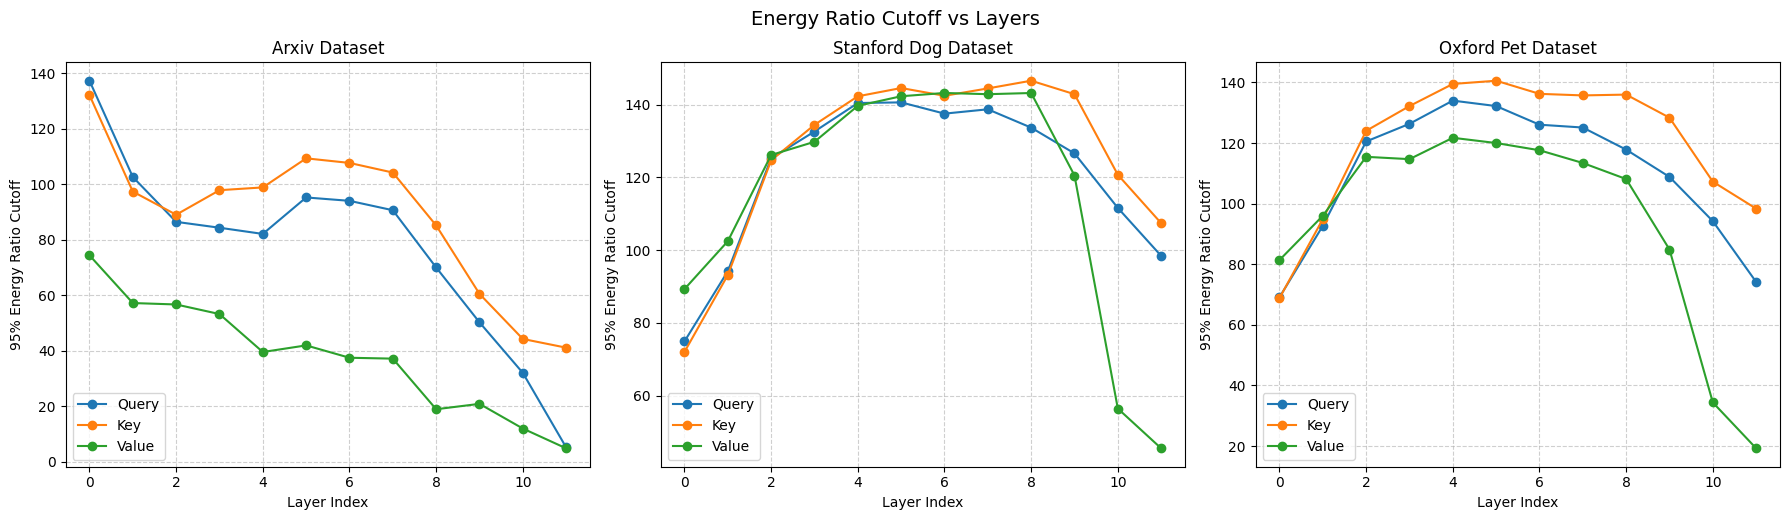

In [177]:
import matplotlib.pyplot as plt
import numpy as np

def plot_coefficients_across_datasets(results_list, dataset_names, coefficient_name, title=None):
    """
    Plots intrinsic dimensionality coefficients (e.g., energy) for Q, K, V matrices against layers or runs.
    Connects the data points with lines for each matrix type.

    Args:
        results_list (list): A list of results dictionaries for each dataset.
        dataset_names (list): A list of dataset names corresponding to the results.
        coefficient_name (str): One of "gini", "elbow", or "energy".
        title (str, optional): Custom title for the entire figure.

    Example Usage:
        plot_coefficients_across_datasets([results1, results2, results3], ["Arxiv", "Stanford", "Oxford"], "energy")
    """
    num_datasets = len(results_list)
    fig, axes = plt.subplots(1, num_datasets, figsize=(6 * num_datasets, 5), sharey=False)

    # Colors for Q, K, V matrices
    colors = {"query": "#1f77b4", "key": "#ff7f0e", "value": "#2ca02c"}

    if not title:
        title = f"{coefficient_name.capitalize()} Coefficient Across Datasets"

    for idx, (results, dataset_name) in enumerate(zip(results_list, dataset_names)):
        ax = axes[idx] if num_datasets > 1 else axes

        # Prepare data
        matrix_types = ["query", "key", "value"]
        layers = results[list(results.keys())[0]]['SVD Diagonal Entries'].keys()
        x_values = np.array([int(layer.split('_')[-1]) for layer in layers])

        for matrix_type in matrix_types:
            y_values = []

            # Collect mean values for each layer
            for layer in layers:
                coefficients = [
                    results[run]["Coefficients"][coefficient_name][layer][matrix_type]
                    for run in results
                ]
                mean_coeff = np.mean(coefficients)
                y_values.append(mean_coeff)

            y_values = np.array(y_values)

            # Plot data points and connect them with lines
            ax.plot(x_values, y_values, '-o', color=colors[matrix_type], label=f'{matrix_type.capitalize()}')

        # Customize each subplot
        ax.set_title(dataset_name, fontsize=12)
        ax.set_xlabel("Layer Index", fontsize=10)
        ax.set_ylabel("95% Energy Ratio Cutoff", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc='lower left')

    # Overall figure adjustments
    plt.tight_layout()
    plt.suptitle("Energy Ratio Cutoff vs Layers", fontsize=14, y=1.03)
    plt.show()

# Example usage
dataset_list = [datasets['arxiv_500_clamped'], datasets['stanford_clamped'], datasets['oxford_clamped']]
dataset_names = ["Arxiv Dataset", "Stanford Dog Dataset", "Oxford Pet Dataset"]

plot_coefficients_across_datasets(dataset_list, dataset_names, "energy")